In [9]:
import os, sys, time
sys.path.append("../src")

from tqdm import tqdm
import numpy as np
import torch
import argparse
from datasets import load_from_disk
from transformers import ViTForImageClassification
from utils.helper import get_device
from utils.vit_util import transforms
from utils.constant import ViTExperiment
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

In [2]:
start_idx = 9
tgt_label = 0

In [3]:
ig_dir = os.path.join(getattr(ViTExperiment, ds_name).OUTPUT_DIR, "results")
base_path = os.path.join(ig_dir, f"base_l{start_idx}tol12_{tgt_label}.npy")
ig_path = os.path.join(ig_dir, f"ig_list_l{start_idx}tol12_{tgt_label}.npy")
base = np.load(base_path)
ig = np.load(ig_path)

In [4]:
base.shape

(5000, 3, 3072)

In [5]:
ig.shape

(5000, 3, 3072)

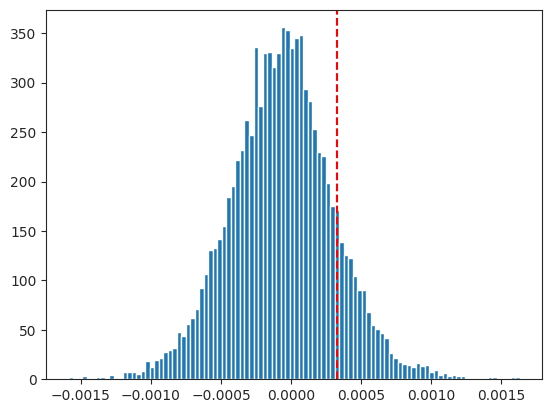

In [10]:
# 例) ig[0]のヒストグラム
plt.hist(ig[0].flatten(), bins=100)
# 横軸がnp.max(ig[0]) * 0.2のところに縦線を引く
plt.axvline(np.max(ig[0]) * 0.2, color='red', linestyle="--")
plt.show()

In [11]:
from collections import Counter
kn_counter = Counter()

# 各サンプルのknowledge neuronを特定したい
for sample_idx, ig_sample in enumerate(ig):
    # t = 各サンプルのスコアの最大値の0.2倍 (サンプルごとのknに対する閾値)
    th_t = np.max(ig_sample) * 0.2
    # th_t以上のサンプルのインデックスのタプルを得る
    idxs = np.where(ig_sample >= th_t)
    # インデックスのタプルを1次元に変換
    t = [(l_id, n_id) for l_id, n_id in zip(idxs[0], idxs[1])]
    kn_counter.update(t)
    print(f"sample_idx: {sample_idx}, #kn candidates: {len(t)}")

sample_idx: 0, #kn candidates: 1224
sample_idx: 1, #kn candidates: 423
sample_idx: 2, #kn candidates: 829
sample_idx: 3, #kn candidates: 636
sample_idx: 4, #kn candidates: 798
sample_idx: 5, #kn candidates: 480
sample_idx: 6, #kn candidates: 326
sample_idx: 7, #kn candidates: 559
sample_idx: 8, #kn candidates: 671
sample_idx: 9, #kn candidates: 359
sample_idx: 10, #kn candidates: 393
sample_idx: 11, #kn candidates: 307
sample_idx: 12, #kn candidates: 261
sample_idx: 13, #kn candidates: 378
sample_idx: 14, #kn candidates: 406
sample_idx: 15, #kn candidates: 1007
sample_idx: 16, #kn candidates: 936
sample_idx: 17, #kn candidates: 852
sample_idx: 18, #kn candidates: 490
sample_idx: 19, #kn candidates: 497
sample_idx: 20, #kn candidates: 493
sample_idx: 21, #kn candidates: 425
sample_idx: 22, #kn candidates: 458
sample_idx: 23, #kn candidates: 882
sample_idx: 24, #kn candidates: 323
sample_idx: 25, #kn candidates: 398
sample_idx: 26, #kn candidates: 513
sample_idx: 27, #kn candidates: 300


In [12]:
# サンプルごとの候補knを集計してレイヤごとにいくつあるか数える
ls = np.array([t[0] for t in kn_counter.keys()])
ls, cnt = np.unique(ls, return_counts=True)
ls, cnt

(array([0, 1, 2]), array([2963, 2962, 2569]))

kn_cnt=3500


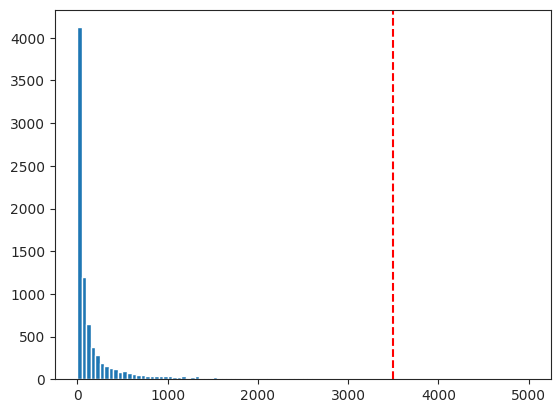

In [18]:
# 特定するknowledge neuronの個数
p = 0.7
kn_cnt = int(ig.shape[0] * p)
print(f"kn_cnt={kn_cnt}")
# kn_counterの値のヒストグラム（knの出現回数）
kn_values = list(kn_counter.values())
plt.axvline(kn_cnt, color='red', linestyle="--")
plt.hist(kn_values, bins=100)
plt.show()

In [22]:
# 同ラベルのサンプルのうちkn_cnt個以上で共有されている知識ニューロンを特定
kn = [(k, v) for k, v in kn_counter.items() if v >= kn_cnt]
len(kn)

110

In [23]:
kn

[((2, 14), 4520),
 ((2, 41), 4140),
 ((2, 69), 4582),
 ((2, 92), 3576),
 ((2, 138), 4599),
 ((2, 139), 4828),
 ((2, 163), 3581),
 ((2, 294), 4990),
 ((2, 302), 4997),
 ((2, 356), 3778),
 ((2, 382), 4123),
 ((2, 389), 3748),
 ((2, 545), 4966),
 ((2, 563), 4702),
 ((2, 582), 4443),
 ((2, 726), 3945),
 ((2, 744), 3976),
 ((2, 746), 4474),
 ((2, 779), 4502),
 ((2, 815), 4313),
 ((2, 828), 3634),
 ((2, 847), 4210),
 ((2, 855), 4473),
 ((2, 879), 4863),
 ((2, 909), 4656),
 ((2, 961), 4946),
 ((2, 1035), 4810),
 ((2, 1085), 4106),
 ((2, 1097), 3604),
 ((2, 1183), 4798),
 ((2, 1290), 4109),
 ((2, 1336), 4893),
 ((2, 1398), 4336),
 ((2, 1435), 4218),
 ((2, 1458), 4916),
 ((2, 1459), 4393),
 ((2, 1480), 4919),
 ((2, 1628), 4985),
 ((2, 1713), 3651),
 ((2, 1731), 4153),
 ((2, 1735), 4456),
 ((2, 1808), 4415),
 ((2, 1838), 3814),
 ((2, 1872), 3811),
 ((2, 1884), 4291),
 ((2, 1891), 4063),
 ((2, 1934), 4167),
 ((2, 2007), 4798),
 ((2, 2020), 4300),
 ((2, 2120), 4077),
 ((2, 2129), 3697),
 ((2, 2136

In [30]:
# サンプルごとの候補knを集計してレイヤごとにいくつあるか数える
ls = np.array([t[0][0] for t in kn])
ls, cnt = np.unique(ls, return_counts=True)
ls, cnt

(array([2]), array([110]))